In [53]:
import pandas as pd
import time
import numpy as np
import json
import os
from collections import defaultdict
from heavy_tail_observations import BothSideWeibullNoise, BothSideParetoNoise, BothSideFrechetNoise
from heavy_tail_lin_bandit import MENU, TOFU, SupHvyLinBandit
from heavy_tail_regressions import _cal_psi, _cal_ap

from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [54]:
data = pd.read_csv("/home/rai/다운로드/train_triplets.txt", sep="\t", names=['user', 'song', 'number of play'])
data = data
data.head()

,user,song,number of play
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1


In [55]:
np.mean(data['number of play'])

2.866858847305635

In [56]:
data.mode()

,user,song,number of play
0,ec6dfcf19485cb011e0b22637075037aae34cf26,SOFRQTD12A81C233C0,1


In [57]:
tracks = pd.read_csv("/home/rai/다운로드/unique_tracks.txt", sep="<SEP>", names=['track', 'song', 'artist', 'title'])
tr = tracks[['track','song']]
tr

/tmp/ipykernel_29205/4175115434.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tracks = pd.read_csv("/home/rai/다운로드/unique_tracks.txt", sep="<SEP>", names=['track', 'song', 'artist', 'title'])


,track,song
0,TRMMMYQ128F932D901,SOQMMHC12AB0180CB8
1,TRMMMKD128F425225D,SOVFVAK12A8C1350D9
2,TRMMMRX128F93187D9,SOGTUKN12AB017F4F1
3,TRMMMCH128F425532C,SOBNYVR12A8C13558C
4,TRMMMWA128F426B589,SOHSBXH12A8C13B0DF
...,...,...
999995,TRYYYUS12903CD2DF0,SOTXAME12AB018F136
999996,TRYYYJO128F426DA37,SOXQYIQ12A8C137FBB
999997,TRYYYMG128F4260ECA,SOHODZI12A8C137BB3
999998,TRYYYDJ128F9310A21,SOLXGOR12A81C21EB7


In [58]:
tag_list = pd.read_csv('/home/rai/다운로드/lastfm_unique_tags.txt',sep='\t',names=['genre','counts'])
tag_list

,genre,counts
0,rock,101071
1,pop,69159
2,alternative,55777
3,indie,48175
4,electronic,46270
...,...,...
522361,´rock,1
522362,Örebro,1
522363,äh,1
522364,ångest,1


In [59]:
tag_freq = tag_list[tag_list['counts']>10000]
tag_freq = list(tag_freq['genre'])
print(len(tag_freq))
tag_freq

86


['rock',
 'pop',
 'alternative',
 'indie',
 'electronic',
 'female vocalists',
 'favorites',
 'Love',
 'dance',
 '00s',
 'alternative rock',
 'jazz',
 'beautiful',
 'singer-songwriter',
 'metal',
 'chillout',
 'male vocalists',
 'Awesome',
 'classic rock',
 'soul',
 'indie rock',
 'Mellow',
 'electronica',
 '80s',
 'folk',
 'british',
 '90s',
 'chill',
 'american',
 'instrumental',
 'punk',
 'oldies',
 'seen live',
 'blues',
 'hard rock',
 'cool',
 'Favorite',
 'ambient',
 'acoustic',
 'experimental',
 'Favourites',
 'female vocalist',
 'guitar',
 'Hip-Hop',
 '70s',
 'party',
 'country',
 'easy listening',
 'sexy',
 'catchy',
 'funk',
 'favourite',
 'electro',
 'heavy metal',
 'Progressive rock',
 '60s',
 'fun',
 'rnb',
 'indie pop',
 'Soundtrack',
 'loved',
 'sad',
 'House',
 'favorite songs',
 'happy',
 'punk rock',
 'piano',
 'psychedelic',
 'hip hop',
 'male vocalist',
 'classic',
 'pop rock',
 'downtempo',
 'trance',
 'melancholy',
 'female',
 'amazing',
 'hardcore',
 'rap',
 'lou

In [60]:
user1 = data.loc[data['user']=='ec6dfcf19485cb011e0b22637075037aae34cf26']
user1

,user,song,number of play
30344428,ec6dfcf19485cb011e0b22637075037aae34cf26,SOAAEUG12A8C137BF1,1
30344429,ec6dfcf19485cb011e0b22637075037aae34cf26,SOAAPTP12A8AE46F86,1
30344430,ec6dfcf19485cb011e0b22637075037aae34cf26,SOAAQIQ12AB0186B18,1
30344431,ec6dfcf19485cb011e0b22637075037aae34cf26,SOAARYO12AF729FDD0,5
30344432,ec6dfcf19485cb011e0b22637075037aae34cf26,SOAAUZS12A8C14666F,1
...,...,...,...
30348823,ec6dfcf19485cb011e0b22637075037aae34cf26,SOZZHQT12AB018B714,1
30348824,ec6dfcf19485cb011e0b22637075037aae34cf26,SOZZNAX12A679AE577,1
30348825,ec6dfcf19485cb011e0b22637075037aae34cf26,SOZZWZV12A67AE140F,1
30348826,ec6dfcf19485cb011e0b22637075037aae34cf26,SOZZXDG12AB0180308,1


In [61]:
max(user1['number of play'])

6

In [62]:
user1 = pd.merge(user1, tr)
user1 = user1.drop(['song'],axis=1)
user1

,user,number of play,track
0,ec6dfcf19485cb011e0b22637075037aae34cf26,1,TRMKHAW128F427D459
1,ec6dfcf19485cb011e0b22637075037aae34cf26,1,TRSLHZY128F425A02F
2,ec6dfcf19485cb011e0b22637075037aae34cf26,1,TRKPLBQ12903CA6100
3,ec6dfcf19485cb011e0b22637075037aae34cf26,5,TRLHMIS128F93253FD
4,ec6dfcf19485cb011e0b22637075037aae34cf26,1,TRHAJSU128F92D7967
...,...,...,...
4403,ec6dfcf19485cb011e0b22637075037aae34cf26,1,TRNBUIB12903CB3E13
4404,ec6dfcf19485cb011e0b22637075037aae34cf26,1,TRJHPKH128E0792D70
4405,ec6dfcf19485cb011e0b22637075037aae34cf26,1,TREFJTL128F147850B
4406,ec6dfcf19485cb011e0b22637075037aae34cf26,1,TRPSKVP128F9301317


In [63]:
with open('/home/rai/다운로드/lastfm_train/A/A/A/TRAAAAK128F9318786.json') as f:
    dt = json.load(f)
dt

{'artist': 'Adelitas Way',
 'timestamp': '2011-08-15 09:59:32.436152',
 'similars': [['TRZNRZF128F9318787', 1],
  ['TRRJFIC128F931879D', 0.966398],
  ['TRLYTDK128F93187BB', 0.158876],
  ['TRQYGQT128F9318777', 0.157267],
  ['TRJYOJG128F93187B4', 0.157267],
  ['TROLOPS128F426E353', 0.11712],
  ['TRQNBAM128F9336E65', 0.107759],
  ['TRILDOA128F426E75F', 0.106884],
  ['TRVFCII128F92F6E7E', 0.0915493],
  ['TRYODCQ12903C9595C', 0.0912093],
  ['TRKTPWS128F427EDCC', 0.0900865],
  ['TRUWAVU128F9336E64', 0.0892342],
  ['TRCXFJG128F427EDC9', 0.0869064],
  ['TRTIYNH128F425249F', 0.0847005],
  ['TRGYGWR128F9338FCB', 0.0824838],
  ['TRLTCTY128F14A65FA', 0.0824838],
  ['TRDSEGT12903D02A53', 0.0824838],
  ['TRZYCVZ12903D02A51', 0.0815291],
  ['TRTPLGZ128EF3405DC', 0.0815291],
  ['TRJQMZC128F9338FC5', 0.0815291],
  ['TRJEFFA128F932106F', 0.0815291],
  ['TRVZNPG128F14A65EF', 0.0815291],
  ['TRKQAWL128F92EB536', 0.0801389],
  ['TRANFIJ128F9366F6F', 0.0800814],
  ['TRQMWBS128F9366F7C', 0.0793406],
  ['TRFX

In [64]:
df = pd.DataFrame(columns=['track', 'tags'])
tags = []
for t in user1['track']:
    path = '/home/rai/다운로드/lastfm_train/' + t[2] + '/' + t[3] + '/' + t[4]
    if t + '.json' in os.listdir(path):
        with open(path + '/' + t + '.json') as f:
            dt = json.load(f)
        df2 = pd.DataFrame({'track' : dt['track_id'], 'tags' : dt['tags']})
        df = df.append(df2, ignore_index=True)
df

,track,tags
0,TRMKHAW128F427D459,"[60s, 100]"
1,TRMKHAW128F427D459,"[female vocalists, 100]"
2,TRMKHAW128F427D459,"[4 little letters, 100]"
3,TRSLHZY128F425A02F,"[pop, 100]"
4,TRSLHZY128F425A02F,"[dance, 43]"
...,...,...
110531,TREFJTL128F147850B,"[Drunken donkey, 0]"
110532,TREFJTL128F147850B,"[soy rudo 1414, 0]"
110533,TREFJTL128F147850B,"[party100910, 0]"
110534,TREFJTL128F147850B,"[e-motion, 0]"


In [65]:
unique_track = set(df['track'])
unique_track

{'TRARIKG128F429A6BE',
 'TRQAGCH128F427F1F3',
 'TREHMMS128F9320B56',
 'TRNUMMX128F92D03F4',
 'TREAHGA128F92EA872',
 'TRSUZEV12903CBDF3D',
 'TROSOFU128F9313F7B',
 'TRNWBBY128F427CFD8',
 'TRGCZAT128F4281BB4',
 'TRLFJZC128F426BE8F',
 'TRULHBN128F14992E1',
 'TRADDAQ12903CBBEA4',
 'TRVAKMV128F9341C3C',
 'TRYUTGP128F9313A89',
 'TRKLHJE128E0795CFB',
 'TRQYOLP128F92DE31F',
 'TRABDPR128F9326104',
 'TRWSOYC128F4220EF6',
 'TRWVRRH128F92F99F2',
 'TRKAIKX128F92DE318',
 'TRIAQMC128F14ADC6C',
 'TRBUZQC128F4262728',
 'TRPWJXQ128F14B0BCD',
 'TRZCMFH128E07819A4',
 'TROTVFA128C7196A4F',
 'TRHLVZF12903CA60F9',
 'TRPGUYI128F4233357',
 'TRUJJZW128F9333441',
 'TRJSGKE128F1464CF2',
 'TRKRCBD128F427D456',
 'TRECKES128E0792E99',
 'TROZJBF128E07940AA',
 'TRGSVRE128F92F671B',
 'TRMDVNU128F145805E',
 'TRTEIIX128F149ADFC',
 'TRMGSUE12903D09C92',
 'TRYDBJI128F424EF84',
 'TRAKGFU128F14A96C2',
 'TRZIGOU128F425CEC4',
 'TRCMRVV128F425A36B',
 'TRJBXNY12903CC7A4F',
 'TRKJPLA128F427776A',
 'TRAGUYM128E0784428',
 'TRARWOI12

In [66]:
tag_set = set([])
for k in df['tags']:
    if k[0] in tag_freq:
        tag_set.add(k[0])

tag_set

{'00s',
 '60s',
 '70s',
 '80s',
 '90s',
 'Awesome',
 'Favorite',
 'Favourites',
 'Hip-Hop',
 'House',
 'Love',
 'Mellow',
 'Progressive rock',
 'Soundtrack',
 'acoustic',
 'alternative',
 'alternative rock',
 'amazing',
 'ambient',
 'american',
 'beautiful',
 'blues',
 'british',
 'catchy',
 'chill',
 'chillout',
 'classic',
 'classic rock',
 'cool',
 'country',
 'cover',
 'dance',
 'downtempo',
 'easy listening',
 'electro',
 'electronic',
 'electronica',
 'experimental',
 'favorite songs',
 'favorites',
 'favourite',
 'female',
 'female vocalist',
 'female vocalists',
 'folk',
 'fun',
 'funk',
 'guitar',
 'happy',
 'hard rock',
 'hardcore',
 'heard on Pandora',
 'heavy metal',
 'hip hop',
 'indie',
 'indie pop',
 'indie rock',
 'instrumental',
 'jazz',
 'lounge',
 'loved',
 'male vocalist',
 'male vocalists',
 'melancholy',
 'metal',
 'new wave',
 'oldies',
 'party',
 'piano',
 'pop',
 'pop rock',
 'psychedelic',
 'punk',
 'punk rock',
 'rap',
 'reggae',
 'relax',
 'rnb',
 'rock',
 '

In [67]:
df2 =  pd.DataFrame(columns = ['track', 'number of play'] + list(tag_set))
for t in unique_track:
    df_t = df[df['track'] == t]
    g = []
    for ta in list(df_t['tags']):
        if ta[0] in tag_set:
            g.append(ta)
    dic = {'track' : t, 'number of play' : list(user1[user1['track']==t]['number of play'])[0]}
    for i in g:
        dic[i[0]] = i[1]
        
    df3 = pd.DataFrame(dic, columns = ['track', 'number of play'] + list(tag_set), index=[0])
    df2 = df2.append(df3, ignore_index=True)
df2 = df2.fillna(0)
df2

,track,number of play,country,punk rock,hip hop,pop rock,cover,techno,american,easy listening,...,cool,favorite songs,female vocalists,male vocalists,sexy,funk,indie pop,70s,Favorite,Mellow
0,TRARIKG128F429A6BE,1,0,0,0,0,0,0,0,0,...,0,0,14,0,0,0,0,0,0,0
1,TRQAGCH128F427F1F3,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,TREHMMS128F9320B56,1,0,0,0,0,0,0,0,0,...,0,0,100,0,0,0,100,0,0,0
3,TRNUMMX128F92D03F4,1,0,0,0,0,100,0,0,0,...,0,0,0,0,0,0,0,0,100,0
4,TREAHGA128F92EA872,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3647,TRCGGHT128F932A9D6,1,0,0,0,0,0,0,0,0,...,0,0,26,0,0,0,0,0,0,0
3648,TRGVYGM128E0799A87,1,0,0,13,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3649,TRKBEGM128F42BA4CD,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3650,TRWGQPM128E0789C87,1,0,20,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
np.mean(df2['number of play'])

1.1933187294633079

In [137]:
np.var(df2['number of play'])

0.7134493365276298

In [69]:
df2 = df2
df3 = df2.drop(['number of play', 'track'],axis=1)
df3 = df3.astype(float)
df3 = df3 / 100
df3

,country,punk rock,hip hop,pop rock,cover,techno,american,easy listening,punk,jazz,...,cool,favorite songs,female vocalists,male vocalists,sexy,funk,indie pop,70s,Favorite,Mellow
0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.14,0.0,0.0,0.0,0.0,0.0,0.0,0.00
1,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.00,0.0,0.0,0.0,1.0,0.0,0.0,0.00
3,0.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.00
4,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3647,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.26,0.0,0.0,0.0,0.0,0.0,0.0,0.00
3648,0.0,0.0,0.13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00
3649,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00
3650,0.0,0.2,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00


In [70]:
y = df2['number of play'].to_numpy()
X = df3.to_numpy()
dim = X.shape[1]
total_samples = len(y)

T = 913
K = int(total_samples/T)

p = 1.5
S = 1.

D = np.reshape(X, (T,K,dim))
R = np.reshape(y, (T,K))

In [71]:
get_mean = lambda x, y: R[y]
get_observation = lambda x, y, z: R[y][z]

In [134]:
error_list = 0

In [135]:
# error_list, theta_star = MENU(D, get_mean, get_observation, S=S, lamb=1., delta=0.01, p=p, c=1.)
# error_list, theta_star = TOFU(D, get_mean, get_observation, S=S, lamb=1., delta=0.01, p=p, b=1.)
error_list, pro_estimator = SupHvyLinBandit(D, get_mean, get_observation, method="proof", S=S, lamb=1., delta=0.001, nu = 1e-4, p=p)
# error_list, btc_estimator = SupHvyLinBandit(D, get_mean, get_observation, method="btc", S=S, lamb=1., delta=0.001, nu = 1., p=p)
# error_list, bmm_estimator = SupHvyLinBandit(D, get_mean, get_observation, method="bmm", S=S, lamb=1., delta=0.001, nu = 1., p=p)

3
[0. 0. 0. 0.]
[1.10721514 0.74729997 2.58872305 2.11368352]
[1.10721514 0.74729997 2.58872305 2.11368352]
[0, 1, 2, 3]
b
end
[       nan        nan 0.13006804        nan]
[1.49459995 0.23913599 1.45628052 0.55461541]
[       nan        nan 1.58634856        nan]
[0, 1, 2, 3]
b
end
[0.15022858 0.35703676 0.04004328 0.02601361]
[1.42777082 2.3284017  1.53440886 1.60832789]
[1.57799941 2.68543846 1.57445214 1.6343415 ]
[0, 1, 2, 3]
b
end
[0.17986551        nan 0.07447568 0.17461779]
[0.58614239 0.         2.01065343 1.79354924]
[0.7660079         nan 2.08512911 1.96816702]
[0, 1, 2, 3]
b
end
[0.54609305        nan 0.39825609        nan]
[1.89808244 2.11368352 1.61150619 0.        ]
[2.44417549        nan 2.00976228        nan]
[0, 1, 2, 3]
b
end
[       nan        nan 0.00156318 0.56348246]
[0.         1.59039762 0.29745199 1.68631168]
[       nan        nan 0.29901517 2.24979414]
[0, 1, 2, 3]
b
end
[0.33631585 0.27343574 0.10417106 0.52940775]
[2.68035592 1.4693698  1.62282107 1.695142

/tmp/ipykernel_29205/4082006313.py:13: RuntimeWarning: invalid value encountered in true_divide
  c = h*Y / thrs


[0.34734998 1.85120158 0.7827582  0.84999382]
[0.50159994 1.11374365 0.77262424 0.78003215]
[0.84894992 2.96494524 1.55538243 1.63002597]
[0, 1, 2, 3]
b
end
[1.44511088 1.79807736 0.99139607        nan]
[0.70226052 1.00567559 1.25510016 0.        ]
[2.14737141 2.80375295 2.24649624        nan]
[0, 1, 2, 3]
b
end
[0.08845382 0.05193685 0.54522556 0.62907334]
[0.0805891  0.21556472 0.84434519 1.40984584]
[0.16904292 0.26750157 1.38957075 2.03891918]
[0, 1, 2, 3]
b
end
[0.7683488  0.56391267        nan 0.04133583]
[0.45749897 0.23636738 0.         0.11852521]
[1.22584777 0.80028005        nan 0.15986103]
[0, 1, 2, 3]
c
1.2258477724405177
[0, 1]
[0. 0. 0. 0.]
[1.49459995 0.51774461 0.         0.14100028]
[1.49459995 0.51774461]
[0, 1]
b
end
[1.728657   0.97616576 0.83149903 1.10927612]
[0.80998667 0.90719523 1.09268961 1.156418  ]
[2.53864367 1.88336099 1.92418864 2.26569412]
[0, 1, 2, 3]
b
end
[0.30248393 0.31445875 1.11254889 0.77323946]
[1.11588795 1.85644321 1.72691033 0.45738218]
[1.4

array([4.        , 2.        , 1.33333333, 1.        , 0.8       ,
       0.66666667, 0.57142857, 0.5       , 0.44444444, 0.4       ,
       0.36363636, 0.66666667, 0.61538462, 0.85714286, 0.8       ,
       0.75      , 0.70588235, 0.66666667, 0.63157895, 0.6       ,
       0.57142857, 0.54545455, 0.69565217, 0.66666667, 0.64      ,
       0.61538462, 0.59259259, 0.57142857, 0.55172414, 0.53333333,
       0.51612903, 0.5       , 0.60606061, 0.58823529, 0.57142857,
       0.55555556, 0.54054054, 0.52631579, 0.51282051, 0.5       ,
       0.48780488, 0.47619048, 0.46511628, 0.45454545, 0.44444444,
       0.43478261, 0.42553191, 0.41666667, 0.40816327, 0.4       ,
       0.47058824, 0.46153846, 0.45283019, 0.44444444, 0.43636364,
       0.42857143, 0.42105263, 0.4137931 , 0.40677966, 0.4       ,
       0.40983607, 0.40322581, 0.3968254 , 0.390625  , 0.38461538,
       0.37878788, 0.37313433, 0.36764706, 0.36231884, 0.41428571,
       0.4084507 , 0.40277778, 0.39726027, 0.39189189, 0.44   

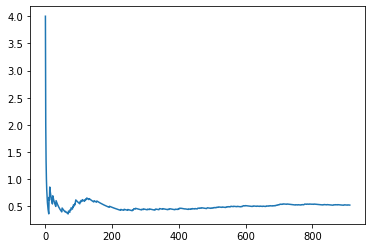

In [136]:
plt.plot(error_list)
error_list